# Matched Distribution on resonance using Xtrack to generate particles
(instead of PyBT)

- Start at resonance
- Add a quadrupole to move away from resonance
- Match a distribution
- Track and collapse quad over a few hundred turns
- You should see the ellipse transform into a triangular shape
- Then start SX

``dQ = Beta(at quad)*integrated_strength [m]*[m^-1]``


In [65]:
import xtrack as xt
import xpart as xp
import xobjects as xo

import pybt

import matplotlib.pyplot as plt

import json
from numpy import random
import random
import numpy as np

from cpymad.madx import Madx

import scipy as sp

# Constants

In [66]:
REL_GAMMA = 25.598474067
REL_BETA = np.sqrt(1-REL_GAMMA**(-2))

exn = 1.5e-6
eyn = 1.5e-6
ex = exn/(REL_BETA*REL_GAMMA)
ey = eyn/(REL_BETA*REL_GAMMA)

p = 24 # beam momentum (GeV/c)
momentum = 24 # beam momentum (GeV/c)
Brho = 24*3.3356

PS_radius = 70.079

TUNE_TARGET = 6.2

SEPTA = True

DPP_FACTOR = 1e-3

# Load PS at East Extraction

In [67]:
mad = Madx(stdout=True)

PS_REPO = "../../../../models/acc-models-ps/"

mad.call(PS_REPO+"ps_mu.seq")
mad.call(PS_REPO+"ps_ss.seq")
mad.call(PS_REPO+"scenarios/east/4_slow_extraction/ps_se_east.str")

mad.command.beam(
    particle="PROTON",
    pc = p,
    ex = ex,
    ey = ey
)
mad.input(f"BRHO      := BEAM->PC * 3.3356;")
mad.use(sequence="PS")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
mad.input('savebeta, label=bumped23, place = PR.BPM23;')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2023.03.17 14:16:27      +
  ++++++++++++++++++++++++++++++++++++++++++++
/**********************************************************************************

*

* Elements description and sequence file for each PS main unit (MU).

*

* 07/10/2020 - Alexander Huschauer

************************************************************************************/



/************************************************************************************

*

*         DEFINITION OF FOCUSING AND DEFOCUSING HALF-UNITS OF THE MU               

*

*************************************************************************************/



/************************************************************************************

*        							 F HALF-UNITS     					            

***********************

True

# Set PFWs, Cycle & Flatten

In [68]:
def tune_match(Qx,Qxp,Qy,Qyp,p,ex,ey):
    
    with open('tempfile', 'w') as f:
        madx = Madx(stdout=f,stderr=f)
        madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

    # Call latice files
    madx.call(PS_REPO+"ps_mu.seq")
    madx.call(PS_REPO+"ps_ss.seq")
    madx.call(PS_REPO+"scenarios/east/4_slow_extraction/ps_se_east.str")

    madx.command.beam(particle='PROTON',
                      pc=p,
                      ex=ex,
                      ey=ey)
    madx.input('BRHO      := BEAM->PC * 3.3356;')

    madx.use(sequence = "PS")
    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
    madx.input('savebeta, label=bumped23, place = PR.BPM23;')
    twiss_initial = madx.twiss().dframe()
    len_ps = twiss_initial.s[-1]

    ### Cycle sequence, changing starting point and adding markers at around the magnet 62
    madx.input('SEQEDIT, sequence=PS;')
    madx.input('FLATTEN;')
    madx.command.install(element = 'marker_ss62_end', class_='MARKER', at=0, from_='SS62$END')
    madx.command.install(element = 'marker_ss63_start', class_='MARKER', at=0, from_='SS63$START')
    madx.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
    madx.input('FLATTEN;')
    madx.input('ENDEDIT;')
    madx.use(sequence='ps')
    madx.select(flag='makethin', class_='rbend', slice_=4)
    madx.select(flag='makethin', class_='quadrupole', slice_=4)
    madx.select(flag='makethin', class_='sbend', slice_=4)
    madx.select(flag='makethin', class_='sextupole', slice_=2)
    madx.makethin(sequence='ps')
    madx.use(sequence='ps')

    twiss_cycled = madx.twiss().dframe()
    
    madx.input('''
    ptc_twiss_macro(order, dp, slice_flag): macro = {
      ptc_create_universe;
      ptc_create_layout, time=false, model=2, exact=true, method=6, nst=3;
      IF (slice_flag == 1){
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,l,x,px,beta11,beta22,disp1,k1l;
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, slice_magnets=true;
      }
      ELSE{
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,x,px,beta11,alfa11,beta22,alfa22,disp1,disp2,mu1,mu2,energy,l,angle,K1L,K2L,K3L,HKICK,SLOT_ID;    
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, normal;
      }
      ptc_end;
    };

    ''')
    
    #/**********************************************************************************
    # *                        Matching using the PFW
    #***********************************************************************************/
    madx.input("Qx   := "+str(Qx)+"; !Horizontal Tune")
    madx.input("Qxp  := "+str(Qxp)+"; !Horizontal Chromaticity")

    madx.input("Qy   := "+str(Qy)+"; !Vertical Tune")
    madx.input("Qyp  := "+str(Qyp)+"; !Vertical Chromaticity")

    madx.input('''
    use, sequence=PS;
    match, use_macro;
            vary, name = k1prpfwf;
            vary, name = k1prpfwd;
            vary, name = k2prpfwf;
            vary, name = k2prpfwd;
            use_macro, name = ptc_twiss_macro(2,0,0);
            constraint, expr = table(ptc_twiss_summary,Q1)  = Qx;
            constraint, expr = table(ptc_twiss_summary,Q2)  = Qy;
            constraint, expr = table(ptc_twiss_summary,DQ1) = Qxp;
            constraint, expr = table(ptc_twiss_summary,DQ2) = Qyp;
    jacobian,calls=50000,bisec=3;
    ENDMATCH;
    ''')
    
    madx.use(sequence="PS")
    twiss_tune_matching = madx.twiss().dframe() # Needed to refresh the tune values
    madx.input('qx = table(SUMM, Q1);')
    madx.input('qy = table(SUMM, Q2);')
    madx.input('qxp = table(SUMM, DQ1);')
    madx.input('qyp = table(SUMM, DQ2);')
    
    tune_info_dict = {"Qx": madx.globals["qx"], "Qy": madx.globals["qy"], "Qxp": madx.globals["qxp"], "Qyp": madx.globals["qyp"]}
    pfw_dict = {"k1prpfwf": madx.globals["k1prpfwf"], "k1prpfwd": madx.globals["k1prpfwd"], "k2prpfwf": madx.globals["k2prpfwf"], "k2prpfwd": madx.globals["k2prpfwd"]}

    print (f"H-tune: {round(tune_info_dict['Qx'],3)}, H-Chroma: {round(tune_info_dict['Qxp'],3)}\nV-Tune: {round(tune_info_dict['Qy'],3)}, V-Chroma: {round(tune_info_dict['Qyp'],3)}")
    print (f"")
    print (f"PFW settings: \n  k1prpfwf: {round(pfw_dict['k1prpfwf'],6)}\n  k1prpfwd: {round(pfw_dict['k1prpfwd'],6)}\n  k2prpfwf: {round(pfw_dict['k2prpfwf'],6)}\n  k2prpfwd: {round(pfw_dict['k2prpfwd'],6)}")

    madx.quit()
    
    return pfw_dict, tune_info_dict

In [69]:
pfw_dict_on_resonance, tune_info_on_resonance = tune_match(Qx=1/3,Qxp=-1.239,Qy=0.3,Qyp=-0.242, p=p, ex=ex, ey=ey) # Chroma from measurements on 12.11.21 

H-tune: 6.333, H-Chroma: -1.24
V-Tune: 6.3, V-Chroma: -0.242

PFW settings: 
  k1prpfwf: 0.000328
  k1prpfwd: -0.000436
  k2prpfwf: 0.013551
  k2prpfwd: -0.022291


In [70]:
mad.input("k1prpfwf = "+str(pfw_dict_on_resonance["k1prpfwf"])+";")
mad.input("k1prpfwd = "+str(pfw_dict_on_resonance["k1prpfwd"])+";")
mad.input("k2prpfwf = "+str(pfw_dict_on_resonance["k2prpfwf"])+";")
mad.input("k2prpfwd = "+str(pfw_dict_on_resonance["k2prpfwd"])+";")
mad.use(sequence="PS")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
mad.input('savebeta, label=bumped23, place = PR.BPM23;')
twiss_initial = mad.twiss().dframe()
len_ps = twiss_initial.s[-1]

mad.input('SEQEDIT, sequence=PS;')
mad.input('FLATTEN;')
mad.command.install(element = 'marker_ss62_end', class_='MARKER', at=0, from_='SS62$END')
mad.command.install(element = 'marker_ss63_start', class_='MARKER', at=0, from_='SS63$START')
mad.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
mad.input('FLATTEN;')
mad.input('ENDEDIT;')
mad.use(sequence = "PS")
twiss_cycled = mad.twiss().dframe()

++++++ info: k1prpfwf redefined
++++++ info: k1prpfwd redefined
++++++ info: k2prpfwf redefined
++++++ info: k2prpfwd redefined
enter Twiss module
  
iteration:   1 error:   1.100297E-03 deltap:   0.000000E+00
orbit:   1.959992E-03  1.722662E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   3.441541E-05 deltap:   0.000000E+00
orbit:   1.943708E-03  1.728124E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   3 error:   4.784001E-10 deltap:   0.000000E+00
orbit:   1.943708E-03  1.728123E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
          628.3185                 -0      0.02556758734        6.253960385 

                q1                dq1            betxmax              dxmax 
       6.353152293        3.671512892        32.40020793        4.420237466 

             dxrms             xcomax             xcorms 

/opt/homebrew/Caskroom/miniconda/base/envs/cern/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


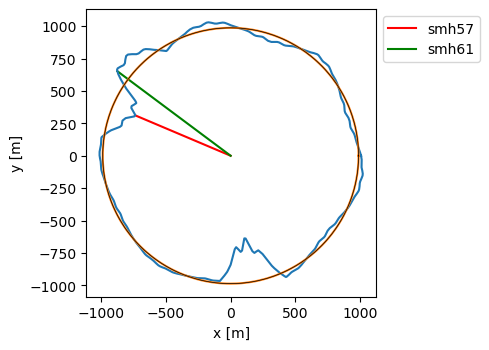

In [71]:
from matplotlib import patches
c = twiss_initial.s[-1]
r = c/2*np.pi

fig, ax = plt.subplots(tight_layout=True, figsize=(5, 5))

x_x = []
x_y = []
for i in range(len(twiss_initial)):
    x = (r+10000*twiss_initial.x[i])*np.cos(twiss_initial.s[i]*2*np.pi/c)
    y = (r+10000*twiss_initial.x[i])*np.sin(-twiss_initial.s[i]*2*np.pi/c) # Clockwise
    x_x.append(x)
    x_y.append(y)

y_x = []
y_y = []
for i in range(len(twiss_initial)):
    x = (r+10000*twiss_initial.y[i])*np.cos(twiss_initial.s[i]*2*np.pi/c)
    y = (r+10000*twiss_initial.y[i])*np.sin(-twiss_initial.s[i]*2*np.pi/c) # Clockwise
    y_x.append(x)
    y_y.append(y)

theta = twiss_initial.s*2*np.pi/c
x = r*np.cos(theta)
y = r*np.sin(theta)

loc_57 = twiss_initial.loc[twiss_initial['name'] == 'pe.smh57:1']['s']
x_57 = (r+10000*twiss_initial.loc[twiss_initial['name'] == 'pe.smh57:1']['x'])*np.cos(loc_57*2*np.pi/c)
y_57 = (r+10000*twiss_initial.loc[twiss_initial['name'] == 'pe.smh57:1']['x'])*np.sin(-loc_57*2*np.pi/c) # Clockwise
# mark 57
ax.plot([0, x_57], [0, y_57], color='red', label='smh57')


loc_61 = twiss_initial.loc[twiss_initial['name'] == 'pe.smh61:1']['s']
x_61 = (r+10000*twiss_initial.loc[twiss_initial['name'] == 'pe.smh61:1']['x'])*np.cos(loc_61*2*np.pi/c)
y_61 = (r+10000*twiss_initial.loc[twiss_initial['name'] == 'pe.smh61:1']['x'])*np.sin(-loc_61*2*np.pi/c) # Clockwise
# mark 61
ax.plot([0, x_61], [0, y_61], color='green', label='smh61')


ax.plot(x_x,x_y)
ax.plot(y_x,y_y)
ax.plot(x, y, color="k", lw=0.5)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_aspect("equal")
ax.legend()
# legend top right
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

###
---

In [72]:
# Makethin
mad.use(sequence='ps')
mad.select(flag='makethin', class_='rbend', slice_=4)
mad.select(flag='makethin', class_='quadrupole', slice_=4)
mad.select(flag='makethin', class_='sbend', slice_=4)
mad.select(flag='makethin', class_='sextupole', slice_=2)
mad.makethin(sequence='ps')

# Convert to Xtrack
mad.use(sequence="PS")
bare_line = xt.Line.from_madx_sequence(
    mad.sequence()
    )
line = xt.Line.from_madx_sequence(
    mad.sequence()
    )
#line = bare_line.filter_elements(exclude_types_starting_with='Cavity')

makethin: slicing sequence : ps
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: - kpebsw57 * 1.06492 * pe.bsw57.59->l / pe.bsw57.53->l 
++++++ warning: division by zero, result set to zero, expr: - kpebsw57 * 1.19887 * pe.bsw57.59->l / pe.bsw57.61->l 
++++++ warning: division by zero, result set to zero, expr: + kpebsw57 * 1.06492 * pe.bsw57.59->l / pe.bsw57.67->l 
++++++ warning: division by zero, result set to 

In [73]:
DETUNE_QUAD_KNL1 = -0.04
# DETUNE_QUAD_KNL1 = 0
detuning_quad = xt.SimpleThinQuadrupole(
    knl = [0, DETUNE_QUAD_KNL1]
)
line.insert_element(
    element = detuning_quad,
    index = 0,
    name = "DETUNING_QUAD"
)
bare_line.insert_element(
    element = detuning_quad,
    index = 0,
    name = "DETUNING_QUAD"
)

In [74]:
# Create monitors
ctx = xo.ContextCpu()

N_PART = int( 5e3 )
N_TURN = int( 5e2 )

line.particle_ref = xp.Particles(
    mass0=xp.PROTON_MASS_EV,
    q0=1,
    p0c=p*sp.constants.c
)

bare_line.particle_ref = xp.Particles(
    mass0=xp.PROTON_MASS_EV,
    q0=1,
    p0c=p*sp.constants.c
)

In [75]:
#[(i, x.to_dict()['__class__']) for i, x in enumerate(line.elements)]

In [76]:
tracker = bare_line.build_tracker()

generating ./dd7dcaddcfa34f1da5bb2471f0b7cb72.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation'


In [77]:
tracker.twiss(method='4d')['qx']

6.257643158994285

In [78]:
#mad_tw = mad.twiss()
# TODO: check eps is normalised emittance

# particles = line.build_particles(method='4d',
#                                  x_norm = [1, 2, 3, 4],
#                                  nemmit_x = exn,
#                                  nemmit_y = eyn)

x_in_sigmas, px_in_sigmas = xp.generate_2D_gaussian(N_PART)

particles = bare_line.build_particles(method='4d',
                    x_norm=x_in_sigmas, # sigmas
                    px_norm=px_in_sigmas, # sigmas
                    nemitt_x=exn, nemitt_y=eyn)


In [79]:
cov = np.cov([particles.x, particles.px])
cov_px = np.cov(particles.px)

In [80]:
w3, h3, r3 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=3)
w2, h2, r2 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=2)
w1, h1, r1 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=1)

In [81]:
co = tracker.find_closed_orbit()
tw = tracker.twiss(method='4d')
parms =  pybt.tools.particles.get_parms(particles.x, particles.px)

Text(0, 0.5, 'px [rad]')

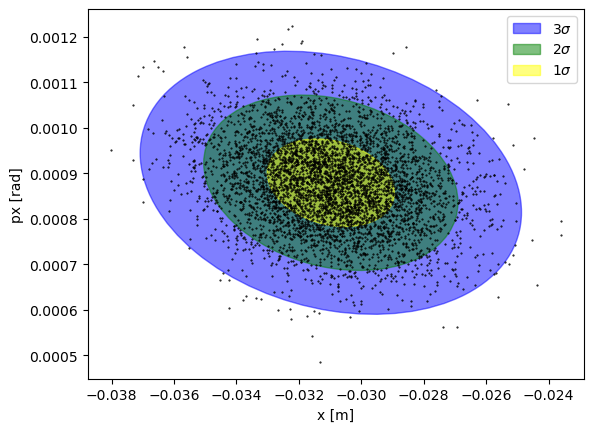

In [82]:
fig, ax = plt.subplots()
ax.plot(particles.x/1, particles.px/1, 'k.', markersize=1)
from matplotlib.patches import Ellipse
e3 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w3, height=h3, angle=r3, color='blue', alpha=.5, label='3$\sigma$')
e2 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w2, height=h2, angle=r2, color='green', alpha=.5, label='2$\sigma$')
e1 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w1, height=h1, angle=r1, color='yellow', alpha=.5, label='1$\sigma$')

ax.add_artist(e3)
ax.add_artist(e2)
ax.add_artist(e1)
ax.plot()
ax.legend()

ax.set_xlabel('x [m]')
ax.set_ylabel('px [rad]')


In [83]:
smh57_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN
)
smh61_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN
)
line.insert_element(
    element = smh57_monitor,
    name = 'SMH57_MONITOR',
    index = 'pe.smh57'
)
line.insert_element(
    element = smh61_monitor,
    name = 'SMH61_MONITOR',
    index = 'pe.smh61'
)

# Perform MAD twiss
mad_twiss = mad.twiss()
mad_twiss_summ = mad_twiss.summary

tracker = line.build_tracker()

# Track
tunes = []
strengths = []
delta = line['DETUNING_QUAD'].knl[1]/N_TURN
for turn in range(N_TURN):
    cur_strength = line['DETUNING_QUAD'].knl[1]
    line['DETUNING_QUAD'].knl[1] = cur_strength - delta
    tracker.track(particles)
    tune = tracker.twiss(method='4d')['qx']
    tunes.append(tune)
    strengths.append(line['DETUNING_QUAD'].knl[1])

enter Twiss module
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * 

In [84]:
tune_before = tw['qx']
print(f"Tune before detune: {tune_before}")
tw = tracker.twiss(method='4d')
tune_after = tw['qx']
print(f"Tune after detune: {tune_after}")

Tune before detune: 6.257643158994285
Tune after detune: 6.333331939399019


In [85]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots(figsize=(7, 7), tight_layout=False)

def animate(i):
    ax.clear()
    #ax.set_aspect("equal")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("px [rad]")
    ax.set_xlim(-0.075, 0.075)
    ax.set_ylim(-0.0015, 0.001)
    fig.suptitle(f"{i:>4} | k1l = {round(strengths[i], 4):>4} | Qx = {round(tunes[i], 3):>4}")
    try:
        ax.scatter(smh57_monitor.x.T[i], smh57_monitor.px.T[i], marker='.', s=2)
    except:
        print("fail at", i)
        pass
    return
ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=False, frames=N_TURN)
ani.save("quad_collapse.gif", writer=PillowWriter(fps=30))


Text(0.5, 1.0, 'Phase space evolution from Qx = 6.2576 to 6.3333')

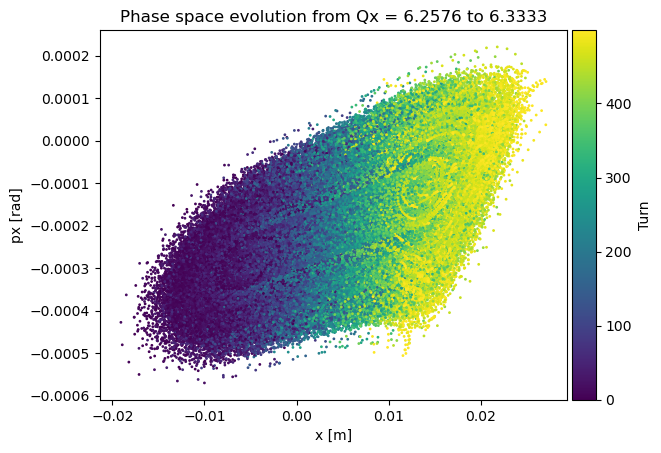

In [86]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

cm = plt.get_cmap("viridis")

fig, ax = plt.subplots()
for i in range(N_PART):
    sctr = ax.scatter(smh57_monitor.x[i], smh57_monitor.px[i], cmap=cm, c=smh57_monitor.at_turn[i], s=1)
ax.set_xlabel('x [m]')
ax.set_ylabel('px [rad]')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sctr, cax=cax, orientation='vertical')
cax.set_ylabel("Turn")
ax.set_title(f"Phase space evolution from Qx = {round(tune_before, 4)} to {round(tune_after, 4)}")

In [144]:
particles_dict = particles.to_dict()

In [145]:
fig, ax = plt.subplots()
ax.scatter(particles_dict['x'], particles_dict['px'], s=2, c='k')

# Into RFKO

In [151]:
line.unfreeze()

In [152]:
EXCITER_SAMPLING_FREQ = 1e6
FREV = 1/tw['T_rev']

CHIRP_START = FREV * .3
CHIRP_STOP = FREV * .35

CHIRP_INTERVAL = 0.001

N_TURN_CHIRP = int( 1e3 )

In [153]:
from signal_gen import generate_chirp

chirp_time, chirp_signal = generate_chirp(
    sampling_freq = EXCITER_SAMPLING_FREQ,
    chirp_start_freq = CHIRP_START,
    chirp_stop_freq = CHIRP_STOP,
    chirp_rep_time = CHIRP_INTERVAL
)

In [154]:
rfko_exciter = xt.Exciter(
    _context = ctx,
    samples = chirp_signal,
    sampling_frequency = EXCITER_SAMPLING_FREQ,
    frev = FREV,
    start_turn = 0,
    knl = [0.001],
    duration = N_TURN_CHIRP/FREV
)
# line.insert_element(
#     element = exciter,
#     name = 'EXCITER',
#     index = 'pr.kfb97'
# )

In [157]:
rfko_tracker = tracker.build_tracker()

In [158]:
rfko_tracker.track(
    particles = rfko_particles, 
    num_turns = N_TURN_CHIRP
)

In [159]:
fig, ax = plt.subplots(figsize=(7, 7), tight_layout=False)

def animate(i):
    ax.clear()
    #ax.set_aspect("equal")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("px [rad]")
    ax.set_xlim(-0.075, 0.075)
    ax.set_ylim(-0.0015, 0.001)
    fig.suptitle(f"{i:>4}")
    try:
        ax.scatter(rfko_smh57_monitor.x.T[i], rfko_smh57_monitor.px.T[i], marker='.', s=2)
    except:
        print("fail at", i)
        pass
    return
ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=False, frames=N_TURN_CHIRP)
ani.save("quad_collapse_rfko.gif", writer=PillowWriter(fps=30))
